In [116]:
from scipy.io import loadmat
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat

import mne

In [117]:
# 1. Load the .mat file
data = loadmat('sampleEEGdata.mat')
EEG = data['EEG']
eeg_data = EEG['data'][0, 0] #eeg_data.shape=(64, 640, 99), [channels:64, time points:640, trials:99]
times = EEG['times'][0, 0][0] #times.shape= (640,)
print('EEG.shape:', EEG.shape) #EEG.shape: (1, 1)
print('eeg_data.shape:', eeg_data.shape) #EEG.shape: (1, 1)
print('times.shape:', times.shape) #EEG.shape: (1, 1)
microvolt = "µV"
################################################################
# Read the file content
with open('eloc64C2.txt', 'r') as f:
    lines = f.readlines()
# Extract channel names, theta, and radius
channel_names = [line.split()[3].replace('.', '') for line in lines[0:]]  # Skip the header
theta = np.array([float(line.split()[1])-90 for line in lines[0:]]) * np.pi / 180.0  # Convert to radians
radius = np.array([float(line.split()[2]) for line in lines[0:]])
# Convert polar to Cartesian
x = radius * np.cos(theta)/5
y = -radius * np.sin(theta)/5
z = np.zeros_like(x)  # default z-coordinate for all channels
# Create a montage
ch_pos = dict(zip(channel_names, zip(x, y, z)))
montage = mne.channels.make_dig_montage(ch_pos, coord_frame='head')
info = mne.create_info(ch_names=channel_names, sfreq=256, ch_types='eeg')
# Apply the montage to the info
info.set_montage(montage)


First_trial_eeg=eeg_data[:,:,0]
# mne.viz.plot_sensors(info, show_names=True, show=True)
raw = mne.io.RawArray(First_trial_eeg, info)

# Set montage and annotations
raw.set_montage(montage)


EEG.shape: (1, 1)
eeg_data.shape: (64, 640, 99)
times.shape: (640,)
Creating RawArray with float64 data, n_channels=64, n_times=640
    Range : 0 ... 639 =      0.000 ...     2.496 secs
Ready.


<RawArray | 64 x 640 (2.5 s), ~410 kB, data loaded>

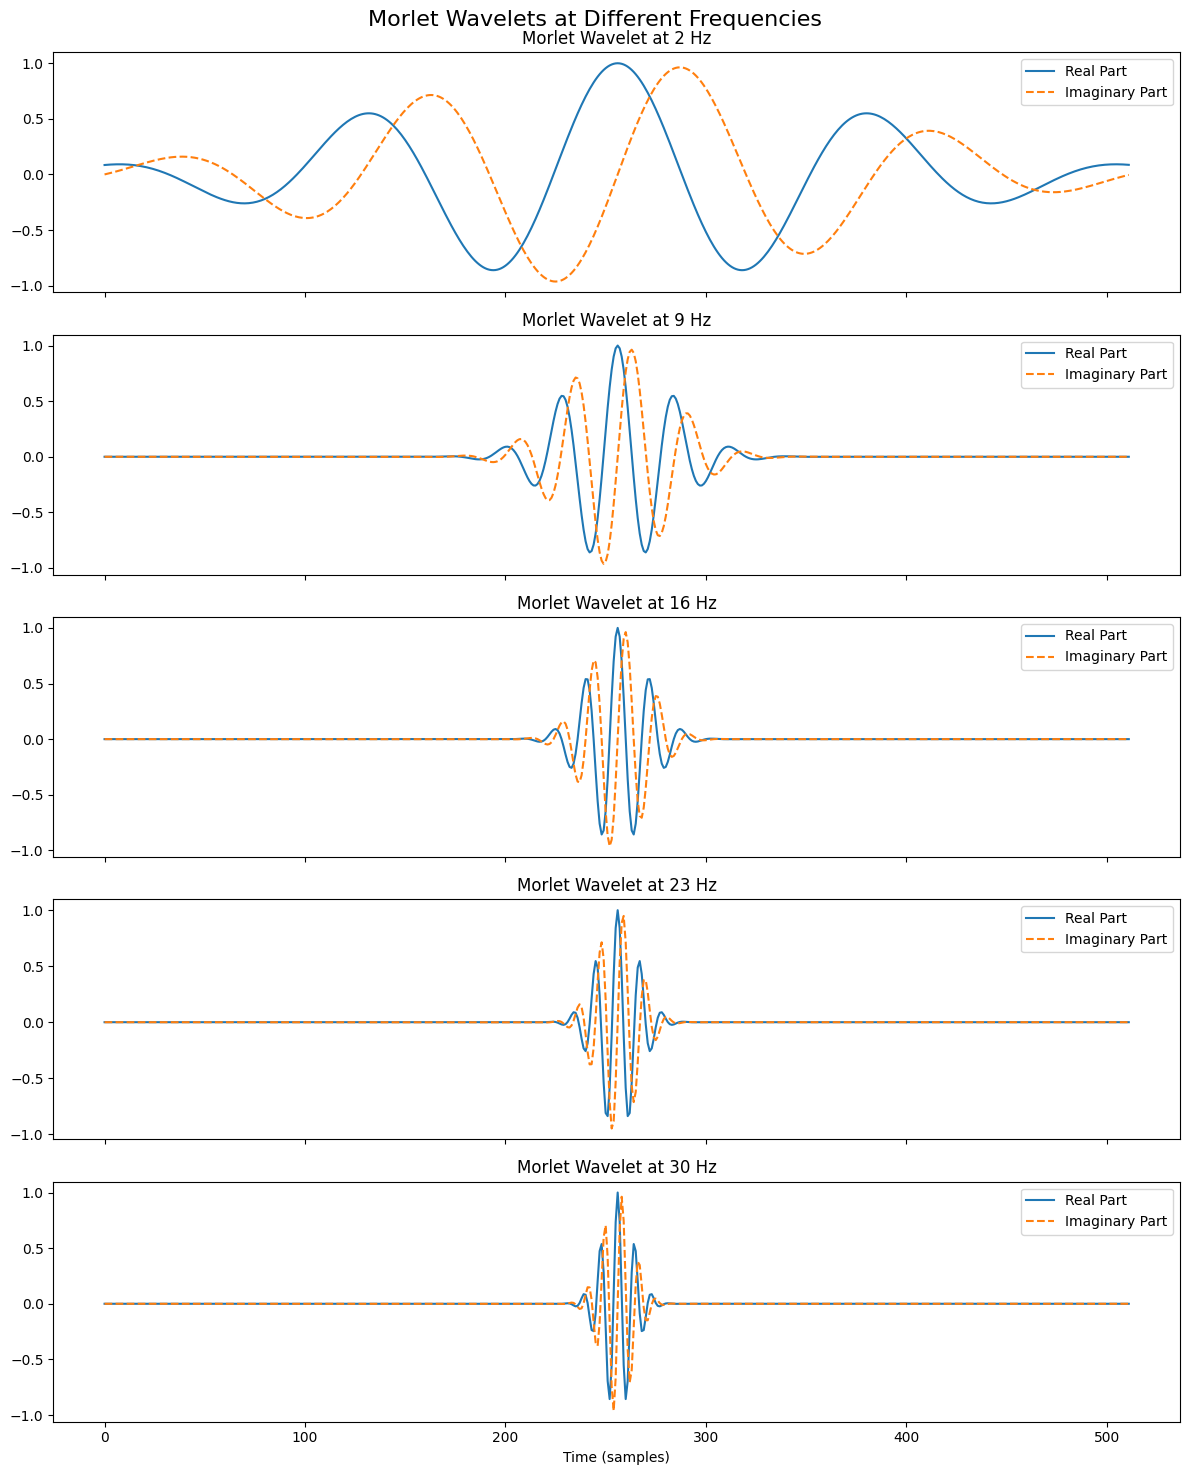

In [118]:
import numpy as np
import matplotlib.pyplot as plt

def morlet_wavelet(frequency, num_cycles, sampling_rate, duration=2):
    t = np.linspace(-duration/2, duration/2, int(sampling_rate * duration), endpoint=False)
    sine_wave = np.exp(2j * np.pi * frequency * t)
    amplitude_envelope = np.exp(-t**2 * (np.pi * frequency / num_cycles)**2)
    wavelet = sine_wave * amplitude_envelope
    return wavelet

# Wavelet parameters
frequencies = [2, 9, 16, 23, 30]
n_cycles = 4
sampling_freq = 256
time_window = 2
wavelets = []  # Empty list to store wavelets

# Plotting
fig, axs = plt.subplots(len(frequencies), 1, figsize=(12, 15), sharex=True)
for i, freq in enumerate(frequencies):
    wavelet = morlet_wavelet(freq, n_cycles, sampling_freq, time_window)
    wavelets.append(wavelet)  # Append wavelet to the list
    axs[i].plot(np.real(wavelet), label='Real Part')
    axs[i].plot(np.imag(wavelet), label='Imaginary Part', linestyle='--')
    axs[i].set_title(f"Morlet Wavelet at {freq} Hz")
    axs[i].legend()

plt.xlabel("Time (samples)")
fig.suptitle('Morlet Wavelets at Different Frequencies', fontsize=16)
plt.tight_layout()
plt.show()


In [119]:
# First_trial_eeg=eeg_data[:,:,0] #shape: (64, 640)
# print(First_trial_eeg.shape)

import numpy as np
from scipy.fft import fft, ifft

# We already have wavelets and their corresponding time vector 't'
convolved_data = np.zeros_like(First_trial_eeg)  # To store the convolved data

# Length of the convolved data
len_convolved = First_trial_eeg.shape[1] + len(t) - 1

for i, wavelet in enumerate(wavelets):
    # FFT of the wavelet
    wavelet_fft = fft(wavelet, n=len_convolved)

    # Convolve with each channel
    for ch in range(First_trial_eeg.shape[0]):
        # FFT of the EEG data
        eeg_fft = fft(First_trial_eeg[ch, :], n=len_convolved)

        # Multiply in frequency domain and then IFFT
        conv_result = ifft(wavelet_fft * eeg_fft)

        # Cut the convolved data to original EEG data length
        cut_length = len(t) // 2
        convolved_data[ch, :] = np.real(conv_result[cut_length:cut_length + First_trial_eeg.shape[1]])

# convolved_data now contains the result of the convolution of each wavelet with each channel's data

# print(convolved_data)  #(64, 640) 

In [121]:
for f_idx, wavelet in enumerate(wavelets):
    wavelet_length = len(wavelet)

    # Calculate the length of the convolved data
    n_convolution = 640 + wavelet_length 

    # FFT of the wavelet
    wavelet_fft = np.fft.fft(wavelet, n=n_convolution)

    for ch_idx in range(64):
        # EEG signal for this channel
        eeg_signal = First_trial_eeg[ch_idx, :]

        # FFT of the EEG signal
        eeg_fft = np.fft.fft(eeg_signal, n=n_convolution)

        # Convolution in the frequency domain
        conv_result_fft = wavelet_fft * eeg_fft

        # Inverse FFT to return to the time domain
        conv_result = np.fft.ifft(conv_result_fft)

        # Correcting the length of the convolved data
        # Ensure integer division and proper trimming
        half_wavelet = int(np.ceil((wavelet_length - 1) / 2))
        conv_result = conv_result[half_wavelet:-half_wavelet or None]

        # Check and adjust the length if necessary
        if conv_result.size != 640:
            raise ValueError(f"Unexpected size of convolved result: {conv_result.size}")

        # Calculate power and phase
        power = np.abs(conv_result) ** 2
        phase = np.angle(conv_result)

        # Store in the matrix
        results_matrix[:, f_idx, ch_idx, 0] = power
        results_matrix[:, f_idx, ch_idx, 1] = phase


In [122]:
# Shape of the entire results_matrix
print("Shape of the results_matrix:", results_matrix.shape)

# To check the shape of power and phase for a specific frequency and electrode
f_idx = 0  # For example, the first frequency
ch_idx = 0  # For example, the first electrode

# Extracting power and phase for this specific frequency and electrode
power_example = results_matrix[:, f_idx, ch_idx, 0]
phase_example = results_matrix[:, f_idx, ch_idx, 1]

print("Shape of power for frequency index", f_idx, "and electrode index", ch_idx, ":", power_example.shape)
print("Shape of phase for frequency index", f_idx, "and electrode index", ch_idx, ":", phase_example.shape)


Shape of the results_matrix: (640, 5, 64, 2)
Shape of power for frequency index 0 and electrode index 0 : (640,)
Shape of phase for frequency index 0 and electrode index 0 : (640,)


C:\Users\tnlab\AppData\Local\Temp\ipykernel_25632\4238666813.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


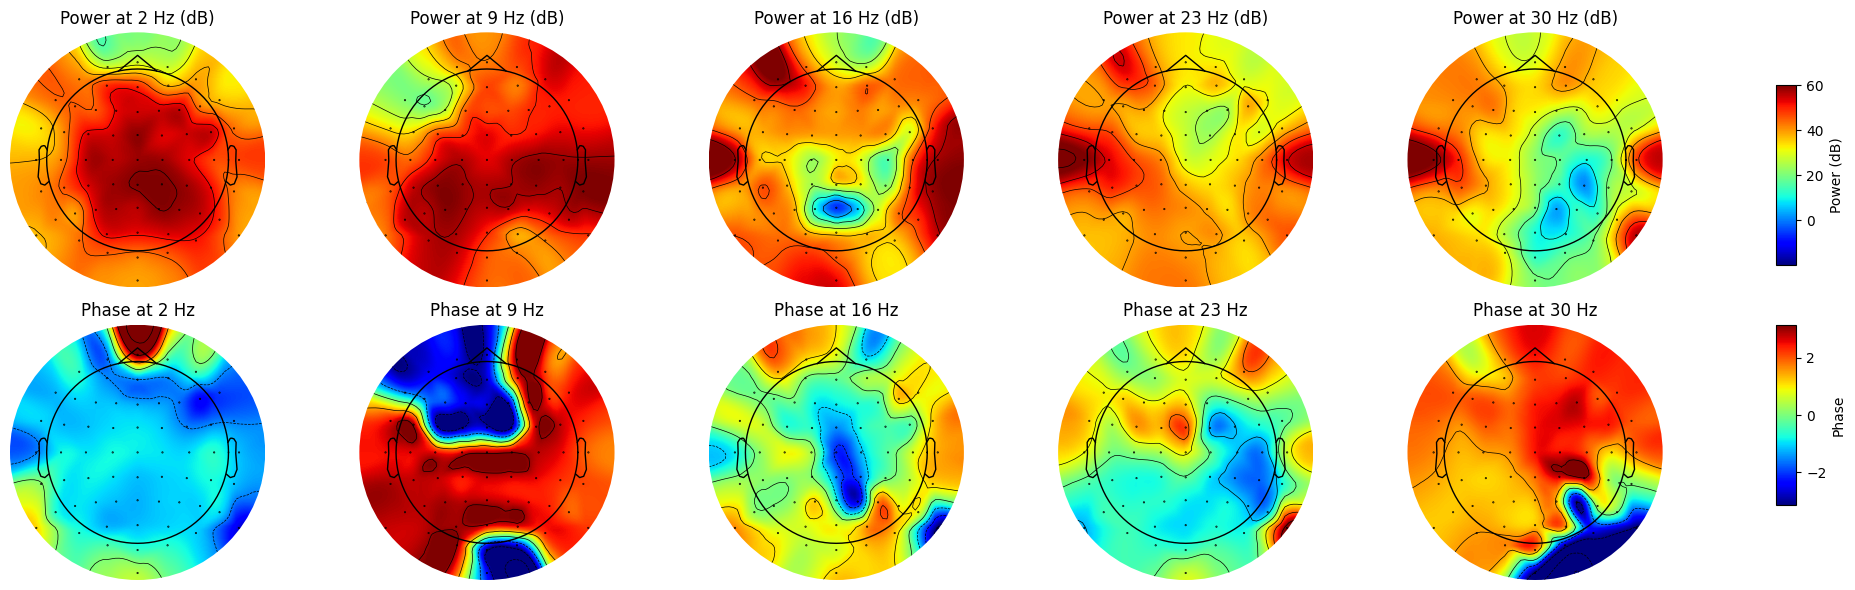

In [134]:
import numpy as np
import matplotlib.pyplot as plt
import mne
from matplotlib.colors import Normalize, NoNorm
from matplotlib.cm import ScalarMappable

# Assuming results_matrix and times are defined as before

# Find the index for 180 ms
time_idx = np.argmin(np.abs(times - 180))

# Define frequencies
frequencies = [2, 9, 16, 23, 30]  # Adjust according to your frequencies

# Calculate the global minimum and maximum for power (in dB) and phase
power_min = 10 * np.log10(results_matrix[:, :, :, 0]).min()
power_max = 10 * np.log10(results_matrix[:, :, :, 0]).max()
phase_min = results_matrix[:, :, :, 1].min()
phase_max = results_matrix[:, :, :, 1].max()

# Set up figure
fig, axs = plt.subplots(2, len(frequencies), figsize=(20, 6))  # Adjust the size as needed

# Loop over frequencies to plot power and phase
for i, freq in enumerate(frequencies):
    # Power (applying 10log10 and normalizing)
    power_data = 10 * np.log10(results_matrix[time_idx, i, :, 0])
    im, _ = mne.viz.plot_topomap(power_data, info, axes=axs[0, i], show=False, cmap='jet')
    axs[0, i].set_title(f'Power at {freq} Hz (dB)')

    # Phase (normalizing)
    phase_data = results_matrix[time_idx, i, :, 1]
    im, _ = mne.viz.plot_topomap(phase_data, info, axes=axs[1, i], show=False, cmap='jet')
    axs[1, i].set_title(f'Phase at {freq} Hz')

# Adding a common colorbar for power
cax1 = fig.add_axes([0.92, 0.55, 0.01, 0.3])  # Adjust these values as needed for positioning
norm = Normalize(vmin=power_min, vmax=power_max)
cb1 = plt.colorbar(ScalarMappable(norm=norm, cmap='jet'), cax=cax1, orientation='vertical')
cb1.set_label('Power (dB)')

# Adding a common colorbar for phase
cax2 = fig.add_axes([0.92, 0.15, 0.01, 0.3])  # Adjust these values as needed for positioning
norm = Normalize(vmin=phase_min, vmax=phase_max)
cb2 = plt.colorbar(ScalarMappable(norm=norm, cmap='jet'), cax=cax2, orientation='vertical')
cb2.set_label('Phase')

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()


C:\Users\tnlab\AppData\Local\Temp\ipykernel_25632\918795317.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


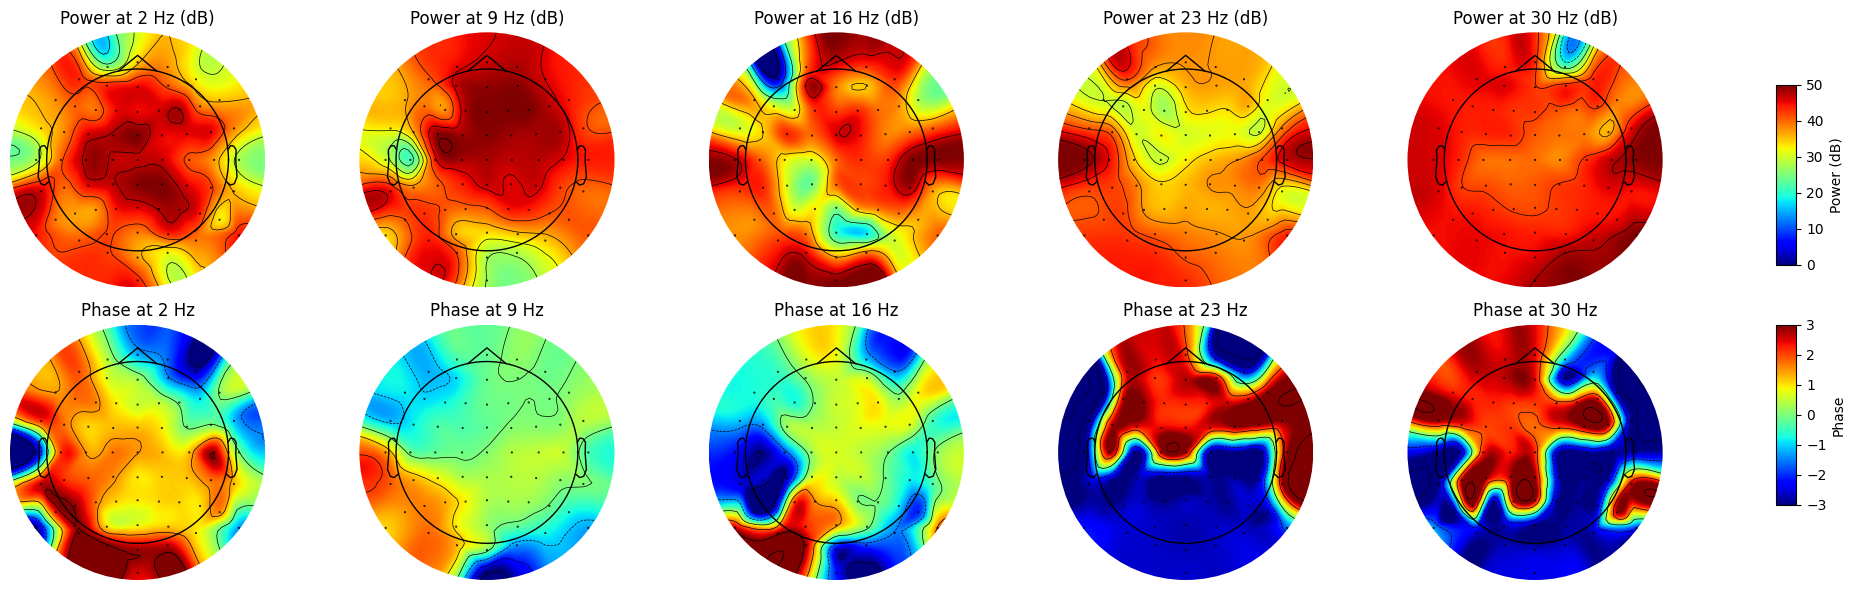

In [124]:
import numpy as np
import matplotlib.pyplot as plt
import mne
from matplotlib.colors import Normalize, NoNorm
from matplotlib.cm import ScalarMappable

# Assuming results_matrix and times are defined as before

# Find the index for 180 ms
time_idx = np.argmin(np.abs(times - 360))

# Define frequencies
frequencies = [2, 9, 16, 23, 30]  # Adjust according to your frequencies

# Calculate the global minimum and maximum for power (in dB) and phase
power_min = 10 * np.log10(results_matrix[:, :, :, 0]).min()
power_max = 10 * np.log10(results_matrix[:, :, :, 0]).max()
phase_min = results_matrix[:, :, :, 1].min()
phase_max = results_matrix[:, :, :, 1].max()

# Set up figure
fig, axs = plt.subplots(2, len(frequencies), figsize=(20, 6))  # Adjust the size as needed

# Loop over frequencies to plot power and phase
for i, freq in enumerate(frequencies):
    # Power (applying 10log10 and normalizing)
    power_data = 10 * np.log10(results_matrix[time_idx, i, :, 0])
    im, _ = mne.viz.plot_topomap(power_data, info, axes=axs[0, i], show=False, cmap='jet')
    axs[0, i].set_title(f'Power at {freq} Hz (dB)')

    # Phase (normalizing)
    phase_data = results_matrix[time_idx, i, :, 1]
    im, _ = mne.viz.plot_topomap(phase_data, info, axes=axs[1, i], show=False, cmap='jet')
    axs[1, i].set_title(f'Phase at {freq} Hz')

# Adding a common colorbar for power
cax1 = fig.add_axes([0.92, 0.55, 0.01, 0.3])  # Adjust these values as needed for positioning
norm = Normalize(vmin=0, vmax=50)
cb1 = plt.colorbar(ScalarMappable(norm=norm, cmap='jet'), cax=cax1, orientation='vertical')
cb1.set_label('Power (dB)')

# Adding a common colorbar for phase
cax2 = fig.add_axes([0.92, 0.15, 0.01, 0.3])  # Adjust these values as needed for positioning
norm = Normalize(vmin=-3, vmax=3)
cb2 = plt.colorbar(ScalarMappable(norm=norm, cmap='jet'), cax=cax2, orientation='vertical')
cb2.set_label('Phase')

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()


C:\Users\tnlab\AppData\Local\Temp\ipykernel_25632\2941234730.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


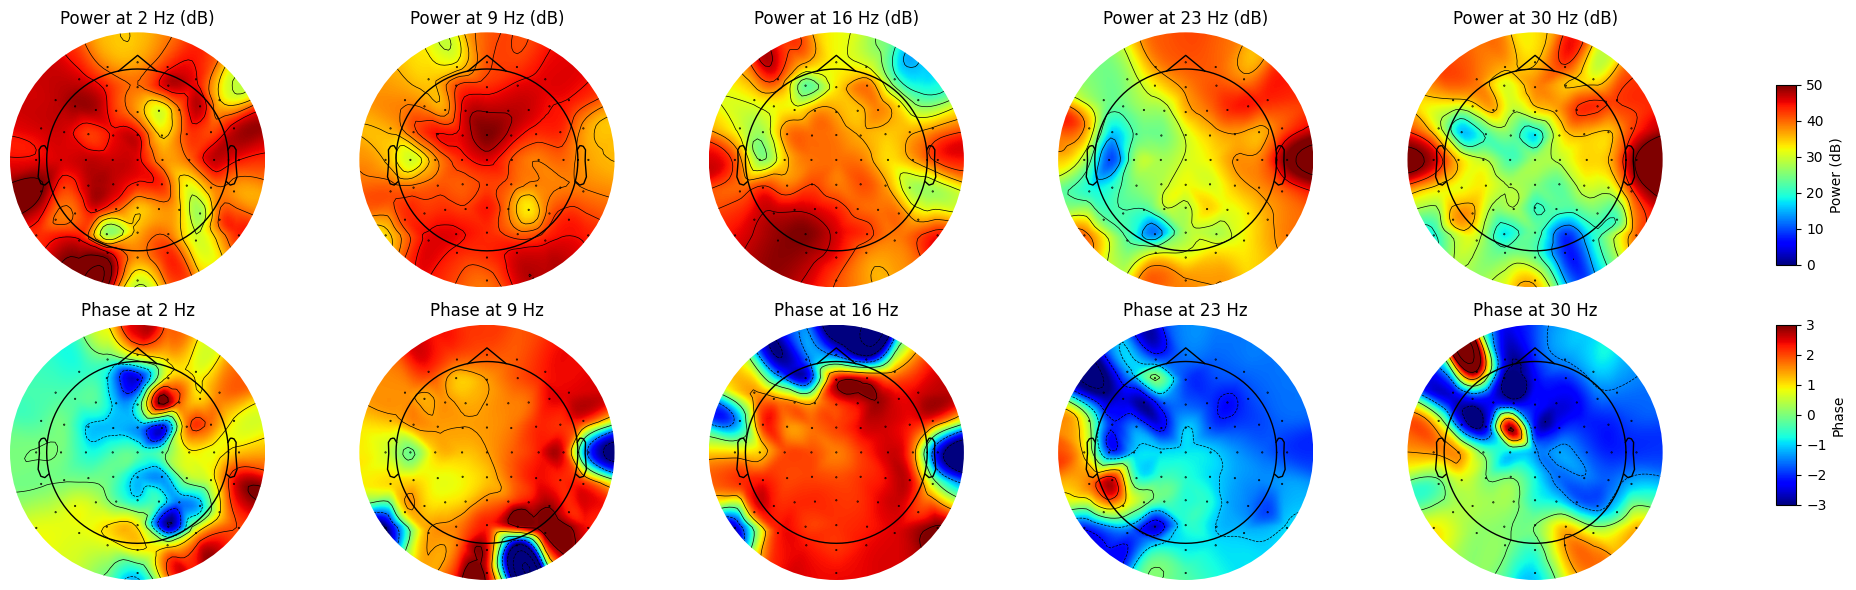

In [125]:
import numpy as np
import matplotlib.pyplot as plt
import mne
from matplotlib.colors import Normalize, NoNorm
from matplotlib.cm import ScalarMappable

# Assuming results_matrix and times are defined as before

# Find the index for 180 ms
time_idx = np.argmin(np.abs(times - 650))

# Define frequencies
frequencies = [2, 9, 16, 23, 30]  # Adjust according to your frequencies

# Calculate the global minimum and maximum for power (in dB) and phase
power_min = 10 * np.log10(results_matrix[:, :, :, 0]).min()
power_max = 10 * np.log10(results_matrix[:, :, :, 0]).max()
phase_min = results_matrix[:, :, :, 1].min()
phase_max = results_matrix[:, :, :, 1].max()

# Set up figure
fig, axs = plt.subplots(2, len(frequencies), figsize=(20, 6))  # Adjust the size as needed

# Loop over frequencies to plot power and phase
for i, freq in enumerate(frequencies):
    # Power (applying 10log10 and normalizing)
    power_data = 10 * np.log10(results_matrix[time_idx, i, :, 0])
    im, _ = mne.viz.plot_topomap(power_data, info, axes=axs[0, i], show=False, cmap='jet')
    axs[0, i].set_title(f'Power at {freq} Hz (dB)')

    # Phase (normalizing)
    phase_data = results_matrix[time_idx, i, :, 1]
    im, _ = mne.viz.plot_topomap(phase_data, info, axes=axs[1, i], show=False, cmap='jet')
    axs[1, i].set_title(f'Phase at {freq} Hz')

# Adding a common colorbar for power
cax1 = fig.add_axes([0.92, 0.55, 0.01, 0.3])  # Adjust these values as needed for positioning
norm = Normalize(vmin=0, vmax=50)
cb1 = plt.colorbar(ScalarMappable(norm=norm, cmap='jet'), cax=cax1, orientation='vertical')
cb1.set_label('Power (dB)')

# Adding a common colorbar for phase
cax2 = fig.add_axes([0.92, 0.15, 0.01, 0.3])  # Adjust these values as needed for positioning
norm = Normalize(vmin=-3, vmax=3)
cb2 = plt.colorbar(ScalarMappable(norm=norm, cmap='jet'), cax=cax2, orientation='vertical')
cb2.set_label('Phase')

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()


In [127]:
def convolve_with_wavelet(data, wavelet):
    n_signal = data.shape[1]
    n_wavelet = len(wavelet)
    n_convolution = n_signal + n_wavelet - 1

    data_fft = np.fft.fft(data, n_convolution, axis=1)
    wavelet_fft = np.fft.fft(wavelet, n_convolution)[np.newaxis, :]

    convolution_result_fft = data_fft * wavelet_fft
    convolution_result = np.fft.ifft(convolution_result_fft, axis=1)

    # Cut the data
    start = (n_wavelet - 1) // 2
    end = start + n_signal
    return convolution_result[:, start:end]


# Function to calculate power for variable or fixed cycles
def calculate_power(cycles):
    power_matrix = []

    for freq, cycle in zip(frequencies, cycles):
        # Extract data for 'FCz'
        data_fcz = eeg_data[fcz_index, :, :]  # Assuming trials are on the second dimension

        # Calculate power for each trial
        power_trials = []
        for trial_idx in range(data_fcz.shape[1]):
            trial_2D = data_fcz[:, trial_idx].reshape(1, -1)  # Making trial 2D for the convolution function
            wavelet = morlet_wavelet(freq, cycle, sampling_rate)
            convolution = convolve_with_wavelet(trial_2D, wavelet)
            power = np.abs(convolution)**2
            power_trials.append(power[0])

        # Average power across trials
        avg_power = np.mean(power_trials, axis=0)
        power_matrix.append(avg_power)

    return np.array(power_matrix)

# Baseline correction function
def baseline_correction(power_matrix, times, baseline_range):
    baseline_timepoints = np.logical_and(times >= baseline_range[0], times <= baseline_range[1])
    baseline_mean = np.mean(power_matrix[:, baseline_timepoints], axis=1, keepdims=True)
    return power_matrix / baseline_mean  # Division for baseline correction

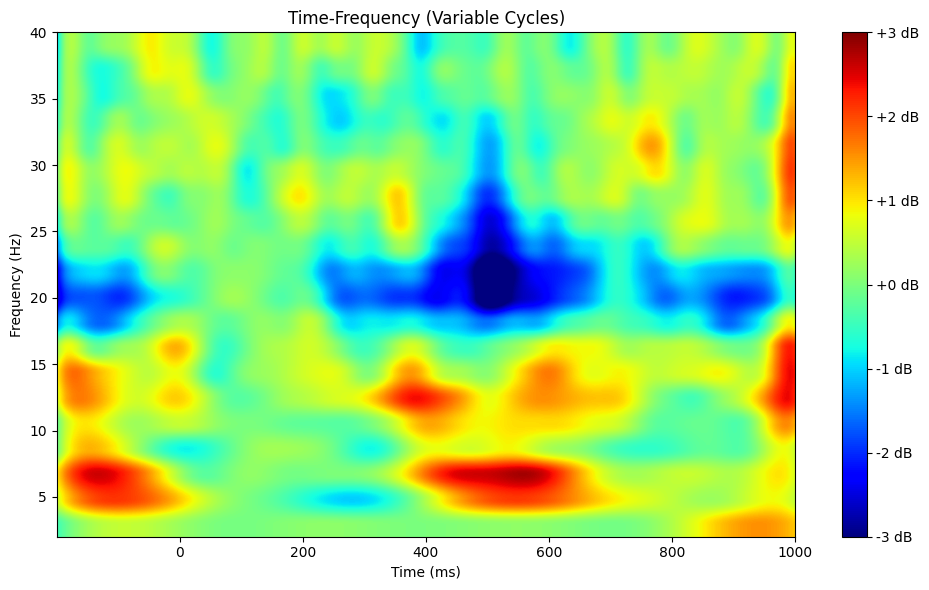

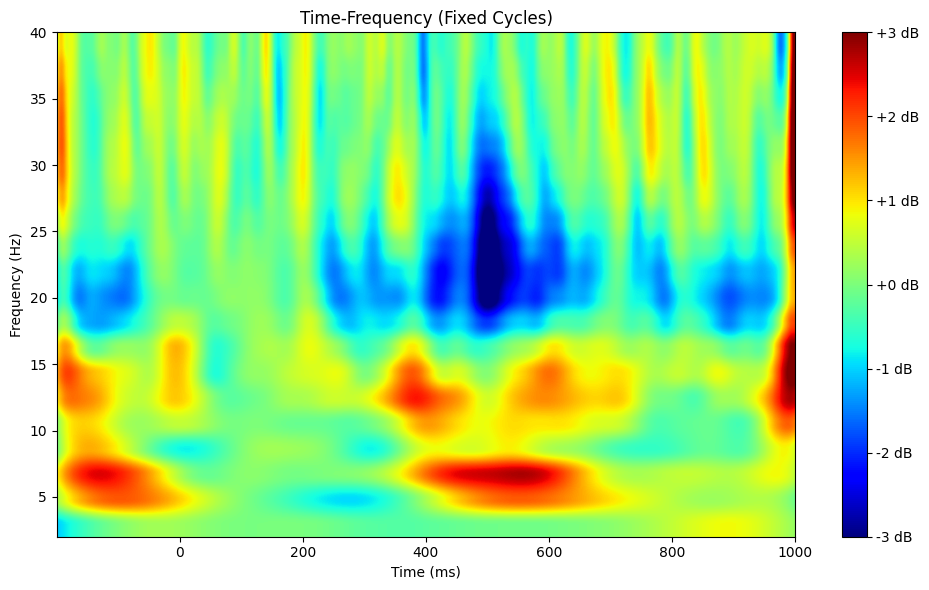

In [133]:
import matplotlib.pyplot as plt

# Constants
baseline_range = (-500, -200)  # in milliseconds
frequencies = np.arange(2, 41, 2)  # 2 to 40 Hz
cycles = np.linspace(3, 10, len(frequencies))  # Variable cycles from 3 to 10
# times = mat_data['EEG']['times'][0, 0][0]
sampling_rate=256
# Find the channel index for 'FCz'
fcz_index = raw.ch_names.index('Fcz')


# Calculate power for variable and fixed cycles
power_variable_cycles = calculate_power(cycles)
power_fixed_cycles = calculate_power([4] * len(frequencies))  # Fixed cycle: 4

# Apply baseline correction
corrected_variable = baseline_correction(power_variable_cycles, times, baseline_range)
corrected_fixed = baseline_correction(power_fixed_cycles, times, baseline_range)

# Plotting function
def plot_time_frequency(data, title):
    plt.figure(figsize=(10, 6))
    plt.imshow(10 * np.log10(data), aspect='auto', cmap='jet', origin='lower',
               extent=[times[205], times[512], frequencies[0], frequencies[-1]],
               vmin=-3, vmax=3)  # Log transform of power; color limits as specified
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (ms)')
    plt.ylabel('Frequency (Hz)')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Plot the results
plot_time_frequency(corrected_variable, 'Time-Frequency (Variable Cycles)')
plot_time_frequency(corrected_fixed, 'Time-Frequency (Fixed Cycles)')

In [132]:
times[205]

-199.21875